Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Anomalies in trip duration, %: 0.74
Trip duration in seconds: 60 to 7191
Empty trips: 17


<ipython-input-34-5581a790a530>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.trip_duration = data.trip_duration.astype(np.uint16)


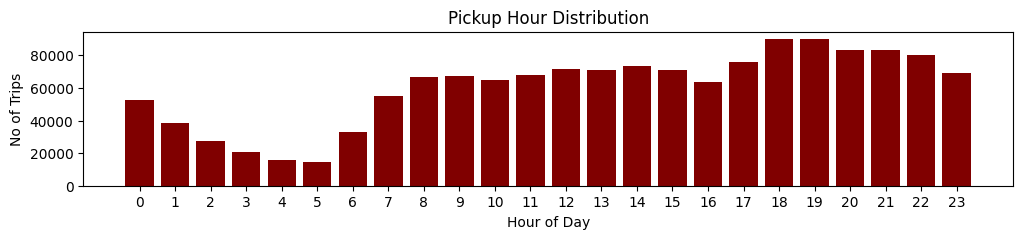

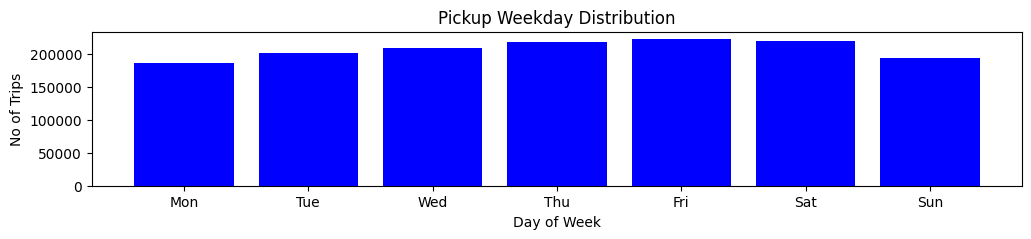

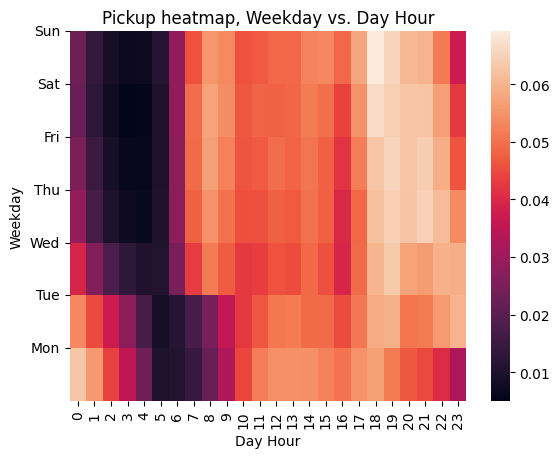

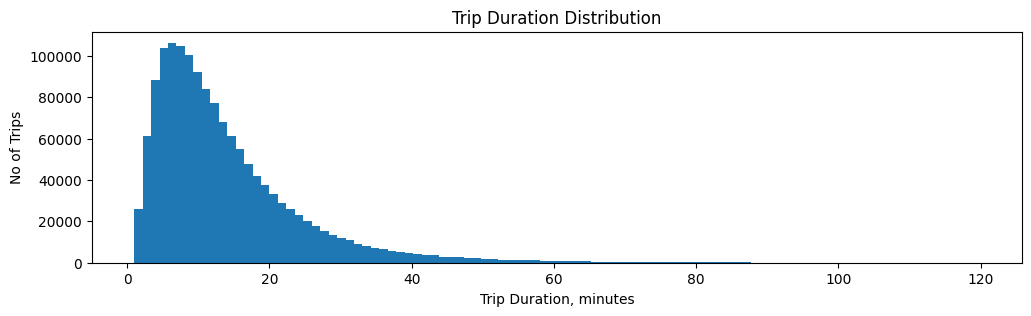

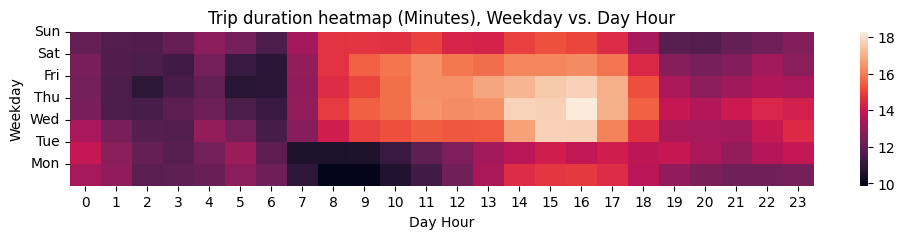

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def clean(data):
   
    # Since there are less than 10k rows with anomalies in trip_duration (in common sense), we can safely remove them
    duration_mask = ((data.trip_duration < 60) | # < 1 min
             (data.trip_duration > 3600 * 2)) # > 2 hours
    print('Anomalies in trip duration, %: {:.2f}'.format(data[duration_mask].shape[0] / data.shape[0] * 100))

    data = data[~duration_mask]
    data.trip_duration = data.trip_duration.astype(np.uint16)
    print('Trip duration in seconds: {} to {}'.format(data.trip_duration.min(), data.trip_duration.max()))

    # Drop trips with passenger count = 0, since there are only 17 of them
    print('Empty trips: {}'.format(data[data.passenger_count == 0].shape[0]))
    data = data[data.passenger_count > 0]

    # Convert this feature into categorical type
    data.store_and_fwd_flag = data.store_and_fwd_flag.astype('category')

    # month (pickup and dropoff)
    data['mm_pickup'] = data.pickup_datetime.dt.month.astype(np.uint8)
    data['mm_dropoff'] = data.dropoff_datetime.dt.month.astype(np.uint8)

    # day of week
    data['dow_pickup'] = data.pickup_datetime.dt.weekday.astype(np.uint8)
    data['dow_dropoff'] = data.dropoff_datetime.dt.weekday.astype(np.uint8)

    # day hour
    data['hh_pickup'] = data.pickup_datetime.dt.hour.astype(np.uint8)
    data['hh_dropoff'] = data.dropoff_datetime.dt.hour.astype(np.uint8)

    plt.figure(figsize=(12,2))
    plt.title('Pickup Hour Distribution')
    plt.xlabel('Hour of Day')
    plt.xticks(range(0,24), rotation='horizontal')
    plt.ylabel('No of Trips')
    plt.bar('hh_pickup', 'id', data=data.groupby(['hh_pickup']).aggregate({'id':'count'}).reset_index(), color ='maroon', width = 0.8)
    plt.show()


    plt.figure(figsize=(12,2))
    plt.title('Pickup Weekday Distribution')
    plt.xlabel('Day of Week')
    plt.xticks(range(0,7), dow_names, rotation='horizontal')
    plt.ylabel('No of Trips')
    plt.bar('dow_pickup', 'id', data=data.groupby('dow_pickup').aggregate({'id':'count'}).reset_index(), color ='blue', width = 0.8)
    plt.show()    

    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.vendor_id, aggfunc='count', normalize='index'))
    plt.title('Pickup heatmap: Weekday vs Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')


    plt.figure(figsize=(12,3))
    plt.title('Trip Duration Distribution')
    plt.xlabel('Trip Duration (Minutes)')
    plt.ylabel('No of Trips')
    plt.hist(data.trip_duration / 60, bins=100)

    plt.figure(figsize=(12,2))
    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.trip_duration/60, aggfunc='mean'))
    plt.title('Trip duration heatmap (Minutes): Weekday vs Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')


if __name__ == '__main__':
    taxiDB = pd.read_csv(filepath_or_buffer='gdrive/My Drive/Meta Heuristic/train.csv', engine='c', infer_datetime_format=True, parse_dates=[2,3])
    clean(taxiDB)
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


# New Section